# Mini Inception Modeling  with Model Subclassing API

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model

print(tf.version.VERSION)

# enable mixed precision
mixed_precision = True
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)

# Conv Module 
class ConvModule(tf.keras.layers.Layer):
	def __init__(self, kernel_num, 
                 kernel_size, strides, padding='same'):
		super(ConvModule, self).__init__()
		self.conv = tf.keras.layers.Conv2D(kernel_num, kernel_size=kernel_size, strides=strides, padding=padding)
		self.bn   = tf.keras.layers.BatchNormalization()

	def call(self, input_tensor, training=False):
		x = self.conv(input_tensor)
		x = self.bn(x, training=training)
		x = tf.nn.relu(x)
		return x 

# Inception Module
class InceptionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size1x1, kernel_size3x3):
        super(InceptionModule, self).__init__()
        self.conv1 = ConvModule(kernel_size1x1, kernel_size=(1,1), strides=(1,1))
        self.conv2 = ConvModule(kernel_size3x3, kernel_size=(3,3), strides=(1,1))
        self.cat   = tf.keras.layers.Concatenate()

    def call(self, input_tensor, training=False):
        x_1x1 = self.conv1(input_tensor)
        x_3x3 = self.conv2(input_tensor)
        x = self.cat([x_1x1, x_3x3])
        return x 

# Downsample Module 
class DownsampleModule(tf.keras.layers.Layer):
	def __init__(self, kernel_size):
		super(DownsampleModule, self).__init__()
		self.conv3 = ConvModule(kernel_size, kernel_size=(3,3), strides=(2,2), padding="valid")
		self.pool  = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2))
		self.cat   = tf.keras.layers.Concatenate()

	def call(self, input_tensor, training=False):
		conv_x = self.conv3(input_tensor, training=training)
		pool_x = self.pool(input_tensor)
		return self.cat([conv_x, pool_x])

# Encompassing Module in Model Class
class MiniInception(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(MiniInception, self).__init__()
        self.conv_block = ConvModule(96, (3,3), (1,1))
        self.inception_block1 = InceptionModule(32, 32)
        self.inception_block2 = InceptionModule(32, 48)
        self.downsample_block1 = DownsampleModule(80)
  
        self.inception_block3 = InceptionModule(112, 48)
        self.inception_block4 = InceptionModule(96, 64)
        self.inception_block5 = InceptionModule(80, 80)
        self.inception_block6 = InceptionModule(48, 96)
        self.downsample_block2 = DownsampleModule(96)

        self.inception_block7 = InceptionModule(176, 160)
        self.inception_block8 = InceptionModule(176, 160)

        self.avg_pool = tf.keras.layers.AveragePooling2D((7,7))
        self.flat = tf.keras.layers.Flatten()
        self.classfier = tf.keras.layers.Dense(num_classes, activation='softmax')


    def call(self, input_tensor, training=False,**kwargs):
        x = self.conv_block(input_tensor)
        x = self.inception_block1(x)
        x = self.inception_block2(x)
        x = self.downsample_block1(x)

        x = self.inception_block3(x)
        x = self.inception_block4(x)
        x = self.inception_block5(x)
        x = self.inception_block6(x)
        x = self.downsample_block2(x)

        x = self.inception_block7(x)
        x = self.inception_block8(x)
        x = self.avg_pool(x)

        x = self.flat(x)
        return self.classfier(x)

    def build_graph(self, shape):
        x = tf.keras.layers.Input(shape=shape)
        return Model(inputs=[x], outputs=self.call(x))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


## Quick Test

In [ ]:
raw_input = (32, 32, 3)

cm = MiniInception()
y  = cm(tf.ones(shape=(0,*raw_input))) # The first call to the `cm` will create the weights

cm.build_graph(raw_input).summary()

# Data Set (CIFAR-10) and Visualization

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


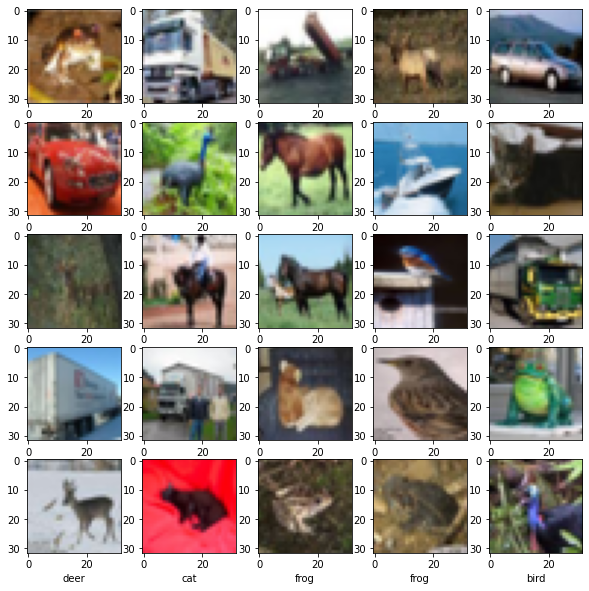

In [2]:
import numpy as np

import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# train set / data 
x_train = x_train.astype('float32') / 255
# validation set / data 
x_test = x_test.astype('float32') / 255


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Custom Loop Training from Scratch

In [3]:
import time 
epochs = 10
batch_size = 256

# train set / target 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# validation set / target 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size)


# for i, (x, y) in enumerate(train_dataset):
#     print(x.shape, y.shape)
    
#     if i == 2:
#         break


# for i, (x, y) in enumerate(val_dataset):
#     print(x.shape, y.shape)
    
#     if i == 2:
#         break

# define model 
model = MiniInception()
# model.build_graph(raw_input).summary()

# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric   = tf.keras.metrics.CategoricalAccuracy()

# tensorboard writer 
train_writer = tf.summary.create_file_writer('logs/train/')
test_writer  = tf.summary.create_file_writer('logs/test/')

@tf.function
def train_step(step, x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        train_loss_value = loss_fn(y, logits)
    grads = tape.gradient(train_loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    
    # write training loss and accuracy to the tensorboard
    with train_writer.as_default():
        tf.summary.scalar('loss', train_loss_value, step=step)
        tf.summary.scalar('accuracy', train_acc_metric.result(), step=step) 
    
    return train_loss_value

@tf.function
def test_step(step, x, y):
    val_logits = model(x, training=False)
    # Compute the loss value f
    val_loss_value = loss_fn(y, val_logits)
    # Update val metrics
    val_acc_metric.update_state(y, val_logits)
    
    # write test loss and accuracy to the tensorboard
    with train_writer.as_default():
        tf.summary.scalar('val loss', val_loss_value, step=step)
        tf.summary.scalar('val accuracy', val_acc_metric.result(), step=step) 

    return val_loss_value

# custom training loop 
for epoch in range(epochs):
    t = time.time()
    # batch training 
    # Iterate over the batches of the dataset.
    for train_batch_step, (x_batch_train,\
                           y_batch_train) in enumerate(train_dataset):
        train_batch_step = tf.convert_to_tensor(train_batch_step, dtype=tf.int64)
        train_loss_value = train_step(train_batch_step, x_batch_train, y_batch_train)

    # evaluation on validation set 
    # Run a validation loop at the end of each epoch.
    for test_batch_step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
        test_batch_step = tf.convert_to_tensor(test_batch_step, dtype=tf.int64)
        val_loss_value = test_step(test_batch_step, x_batch_val, y_batch_val)

    template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
    print(template.format(
        round((time.time() - t)/60, 2), epoch + 1,
        train_loss_value, float(train_acc_metric.result()),
        val_loss_value, float(val_acc_metric.result())
    ))
        
    # Reset metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

ETA: 0.82 - epoch: 1 loss: 0.77685546875  acc: 0.5814200043678284 val loss: 2.41796875 val acc: 0.14239999651908875

ETA: 0.31 - epoch: 2 loss: 0.546875  acc: 0.7408599853515625 val loss: 1.5419921875 val acc: 0.506600022315979

ETA: 0.3 - epoch: 3 loss: 0.4990234375  acc: 0.8113600015640259 val loss: 1.26953125 val acc: 0.505299985408783

ETA: 0.31 - epoch: 4 loss: 0.439453125  acc: 0.8497200012207031 val loss: 0.98486328125 val acc: 0.5541999936103821

ETA: 0.3 - epoch: 5 loss: 0.37255859375  acc: 0.8799200057983398 val loss: 1.513671875 val acc: 0.49939998984336853

ETA: 0.32 - epoch: 6 loss: 0.1861572265625  acc: 0.9054800271987915 val loss: 0.43994140625 val acc: 0.7206000089645386

ETA: 0.28 - epoch: 7 loss: 0.1112060546875  acc: 0.9297599792480469 val loss: 0.861328125 val acc: 0.616100013256073

ETA: 0.33 - epoch: 8 loss: 0.132568359375  acc: 0.943120002746582 val loss: 1.5693359375 val acc: 0.6001999974250793

ETA: 0.3 - epoch: 9 loss: 0.07989501953125  acc: 0.9575200080871582

# Inference 

In [6]:
import numpy as np 
from tensorflow.keras.preprocessing import image

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Give the link of the image here to test 
test_image1 = image.load_img('1.jpeg', target_size=(32,32))
test_image  = image.img_to_array(test_image1) 
test_image  = np.expand_dims(test_image, axis =0) 
prediction  = model.predict(test_image)[0] 
label_index = np.argmax(prediction)
class_names[label_index]

bird


# Classification Report and Confusion Matrix

313/313 - 1s
              precision    recall  f1-score   support

    airplane       0.81      0.79      0.80      1000
  automobile       0.76      0.95      0.85      1000
        bird       0.78      0.65      0.71      1000
         cat       0.36      0.92      0.51      1000
        deer       0.94      0.49      0.65      1000
         dog       0.87      0.46      0.60      1000
        frog       0.97      0.52      0.68      1000
       horse       0.89      0.69      0.78      1000
        ship       0.83      0.90      0.86      1000
       truck       0.90      0.81      0.85      1000

    accuracy                           0.72     10000
   macro avg       0.81      0.72      0.73     10000
weighted avg       0.81      0.72      0.73     10000



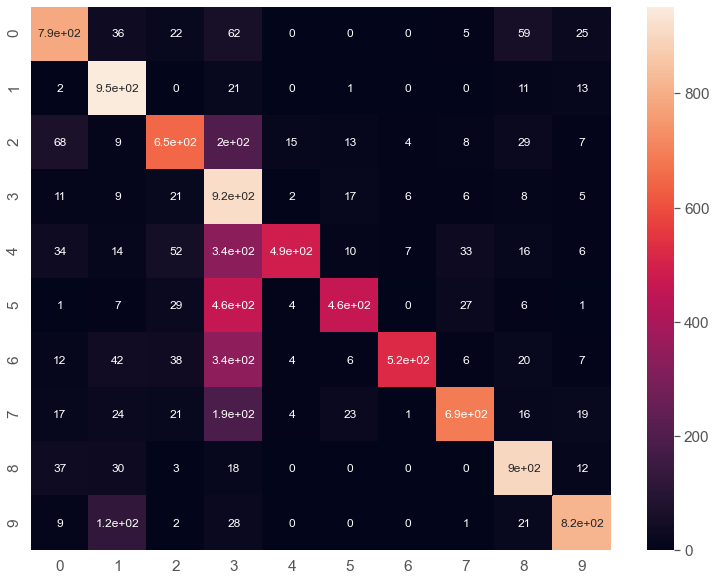

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas  as pd

Y_pred = model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

 
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

    
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (13,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test,y_pred))

ROC AUC score: 0.8436111111111112


# Save Model (Entire Model)


In [ ]:
model.save('net',save_format='tf')
re_load_model = tf.keras.models.load_model("net", compile=False)

In [ ]:
model.save_weights('net.h5')

# Save Weight and Re-Load Weight

In [ ]:
new_model = MiniInception()
new_model.load_weights('net.h5')

In [ ]:
new_model = MiniInception()
new_model.build((None, *x_train.shape[1:])) # new_model.build((x_train.shape))
new_model.load_weights('net.h5')

In [ ]:
new_model.build_graph(raw_input).summary()

# END